In [ ]:
import argparse
import os
import sys

import fipy as fp
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

'''
parser = argparse.ArgumentParser(description="DeepONet with configurable parameters.")
parser.add_argument('--var', type=int, default=0, help='Variant of DeepONet')
# 解析命令行参数
args = parser.parse_args()
var = args.var
'''
var = 1

In [ ]:
# In this cell, we define the configurable parameters for the DeepONet

time_limit = 1
time_step = 0.01
n_points = 50
total_time_steps = int(time_limit/time_step)
total_sample = 500
boundary = int(total_sample*4/5) # 设置训练集和测试集的边界
batch_size = 20
hidden_dims = [200,200,200,200]
output_dim = 50


# Hyperparameters
branch_input_dim = n_points  # Number of points to represent the original function
trunk_input_dim = 2     # Coordinate where we evaluate the transformed function

In [59]:
# In this cell, we define the function to get the cell centers of a 1D mesh. 
# Also, we set up the spatial and temporal grid points for the training and testing datasets.
# This is the so-called y_expanded tensor. 
def get_cell_centers(time_limit = 1, n_points = 50):
    """
    Get the cell center positions for a 1D mesh with the specified number of grid points.

    Parameters:
    - n_points: Number of grid points in the spatial domain.

    Returns:
    - cell_centers: The x-positions of the cell centers.
    """
    L = time_limit  # Length of the domain
    dx = L / n_points

    # Create a 1D mesh
    mesh = fp.Grid1D(nx=n_points, dx=dx)

    # Get the cell center positions
    cell_centers = mesh.cellCenters[0]  # These are the x-positions of the cell centers
    cell_centers = np.array(cell_centers)

    return cell_centers

# Example usage:
cell_centers = get_cell_centers(n_points=n_points)
cell_centers = np.around(cell_centers, decimals=2)

time_steps = np.arange(time_step, time_limit+time_step, time_step)
time_steps = np.around(time_steps, decimals=2)

Y1, Y2 = np.meshgrid(cell_centers, time_steps)  # 第一个变量进行行展开，第二个变量进行列展开

y = np.column_stack([Y2.ravel(),Y1.ravel()]) 
# 先将 Y2 和 Y1 进行展开，然后将展开后的两个向量进行列合并

y_tensor = torch.tensor(y, dtype=torch.float)
print(f"The dimension of y_tensor is {y_tensor.shape}.")
y_expanded = y_tensor.unsqueeze(0).expand(total_sample, -1, -1)
print(f"The dimension of y_expanded is {y_expanded.shape} after expanding.")



The dimension of y_tensor is torch.Size([5000, 2]).
The dimension of y_expanded is torch.Size([500, 5000, 2]) after expanding.


In [60]:
# In this cell, we load the initial conditions and solutions from the saved files.

# Define the directory where you want to save the file
from pathlib import Path
# Get the current directory
current_dir = Path.cwd()
#data_directory = os.path.join(current_dir.parent, 'data')
data_directory = os.path.join(current_dir, 'data')
initials_name = f'heat_initials_{len(cell_centers)}.npy'
solutions_name = f'heat_solutions_{len(cell_centers)}.npy'

# Define the file paths
initials_path = os.path.join(data_directory, initials_name)
solutions_path = os.path.join(data_directory, solutions_name)

# Load the data
initials = np.load(initials_path)
solutions = np.load(solutions_path)

print(f"The dimensions of the initial conditions are: {initials.shape}")
print(f"The dimensions of the solutions are: {solutions.shape}")



The dimensions of the initial conditions are: (500, 50)
The dimensions of the solutions are: (500, 100, 50)


In [61]:
# In this cell, we arrange the initial conditions into the desired format for training the DeepONet.
# This is the so-called u_expanded tensor.
u_tensor = torch.tensor(initials, dtype=torch.float)
print(f"The dimension of u_tensor is {u_tensor.shape}.")

u_expanded = u_tensor.unsqueeze(1) # u_expanded: tensor[total_sample, 1, n_points]
u_expanded = u_expanded.expand(-1, total_time_steps*n_points, -1) # u_expanded: tensor[total_sample, total_time_steps*n_points, n_points]
print(f"The dimension of u_expanded is {u_expanded.shape} after expanding.")


The dimension of u_tensor is torch.Size([500, 50]).
The dimension of u_expanded is torch.Size([500, 5000, 50]) after expanding.


In [62]:
# In this cell, we arrange the solutions into the desired format for training the DeepONet.
# This is the so-called s_expanded tensor.

solutions_linear = np.zeros((total_sample, total_time_steps*n_points))

for i in range(total_sample):
    solutions_linear[i] = solutions[i].flatten()

# solutions is a 3D array of shape (total_sample, total_time_steps, n_points)
print(f"The loaded solution dataset has dimension {solutions.shape},\n\t while the arranged linearized dataset has dimension {solutions_linear.shape}.")

s_tensor  = torch.tensor(solutions_linear, dtype=torch.float) # s_tensor: tensor[total_sample, total_time_steps*n_points]
s_expanded  = s_tensor.unsqueeze(2) # s_expanded: tensor[total_sample, total_time_steps*n_points, 1]

print(f"The dimension of s_tensor is {s_tensor.shape}.")
print(f"The dimension of s_expanded is {s_expanded.shape} after expanding.")



The loaded solution dataset has dimension (500, 100, 50),
	 while the arranged linearized dataset has dimension (500, 5000).
The dimension of s_tensor is torch.Size([500, 5000]).
The dimension of s_expanded is torch.Size([500, 5000, 1]) after expanding.


In [63]:
"""
This is the function to well organize the dataset
"""
class CustomDataset(Dataset):
    def __init__(self, input1_data, input2_data, targets):
        self.input1_data = input1_data
        self.input2_data = input2_data
        self.targets = targets

    def __len__(self):
        return len(self.input1_data)

    def __getitem__(self, idx):
        input1 = self.input1_data[idx]
        input2 = self.input2_data[idx]
        target = self.targets[idx]
        return input1, input2, target


In [64]:
train_set = CustomDataset(u_expanded[:boundary], y_expanded[:boundary], s_expanded[:boundary])
test_set = CustomDataset(u_expanded[boundary:], y_expanded[boundary:], s_expanded[boundary:])

# 创建 DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1) 
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1) 



In [65]:
"""
Design DeepONet Components.
"""
# Branch Network
class BranchNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(BranchNet, self).__init__()
        layers = []
        in_dim = input_dim
        
        # 添加多个隐藏层
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ELU())
            in_dim = h_dim
        
        layers.append(nn.Linear(in_dim, output_dim))
        self.fc = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.fc(x)

# Trunk Network
class TrunkNet(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(TrunkNet, self).__init__()
        layers = []
        in_dim = input_dim
        
        # 添加多个隐藏层
        for h_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ELU())
            in_dim = h_dim
        
        layers.append(nn.Linear(in_dim, output_dim))
        self.fc = nn.Sequential(*layers)
        
    def forward(self, y):
        return self.fc(y)


In [66]:
# In this cell, we define the DeepONet Variants
class DeepONet_0(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dims, output_dim):
        super(DeepONet_0, self).__init__()
        self.branch_net = BranchNet(branch_input_dim, hidden_dims, output_dim)
        self.trunk_net = TrunkNet(trunk_input_dim, hidden_dims, output_dim)
        
    def forward(self, x, yy):
        branch_output = self.branch_net(x)
        trunk_output = self.trunk_net(yy)
        # Combine the outputs (typically element-wise product)
        output = torch.sum(branch_output * trunk_output, dim=-1, keepdim=True) # 按照最后一个坐标做内积
        return output
    
class DeepONet_1(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dims, output_dim):
        super(DeepONet_1, self).__init__()
        self.branch_net = BranchNet(branch_input_dim+1, hidden_dims, output_dim)
        self.trunk_net = TrunkNet(trunk_input_dim, hidden_dims, output_dim)
        
    def forward(self, x, yy):
        y_part = yy[:, :, -1].unsqueeze(-1)
        x_extend = torch.cat((x, y_part), dim=-1)
        branch_output = self.branch_net(x_extend)
        
        trunk_output = self.trunk_net(yy)
        
        # Combine the outputs (typically element-wise product)
        output = torch.sum(branch_output * trunk_output, dim=-1, keepdim=True) # 按照最后一个坐标做内积
        return output

class DeepONet_2(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dims, output_dim):
        super(DeepONet_2, self).__init__()
        self.branch_net = BranchNet(branch_input_dim, hidden_dims, output_dim)
        self.trunk_net = TrunkNet(trunk_input_dim+1, hidden_dims, output_dim)
        
    def forward(self, x, yy):
        branch_output = self.branch_net(x)
        
        corresponding_initial = torch.zeros(x.shape[0], x.shape[1], 1)
        corresponding_initial = corresponding_initial.to(device)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                corresponding_index = (yy[i,j,1]-1/(2*n_points))*n_points
                corresponding_index = corresponding_index.item()
                corresponding_index = np.rint(corresponding_index).astype(int)
                corresponding_initial[i,j,0] = x[i,j,corresponding_index]
        y_extend = torch.cat((yy, corresponding_initial), dim=-1)
        trunk_output = self.trunk_net(y_extend)
        
        # Combine the outputs (typically element-wise product)
        output = torch.sum(branch_output * trunk_output, dim=-1, keepdim=True) # 按照最后一个坐标做内积
        return output
    
class DeepONet_3(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dims, output_dim):
        super(DeepONet_3, self).__init__()
        self.branch_net = BranchNet(branch_input_dim+1, hidden_dims, output_dim)
        self.trunk_net = TrunkNet(trunk_input_dim+1, hidden_dims, output_dim)
        
    def forward(self, x, yy):
        y_part = yy[:, :, -1].unsqueeze(-1)
        x_extend = torch.cat((x, y_part), dim=-1)
        branch_output = self.branch_net(x_extend)
        
        corresponding_initial = torch.zeros(x.shape[0], x.shape[1], 1)
        corresponding_initial = corresponding_initial.to(device)
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                corresponding_index = (yy[i,j,1]-1/(2*n_points))*n_points
                corresponding_index = corresponding_index.item()
                corresponding_index = np.rint(corresponding_index).astype(int)
                corresponding_initial[i,j,0] = x[i,j,corresponding_index]
        y_extend = torch.cat((yy, corresponding_initial), dim=-1)
        trunk_output = self.trunk_net(y_extend)
        
        # Combine the outputs (typically element-wise product)
        output = torch.sum(branch_output * trunk_output, dim=-1, keepdim=True) # 按照最后一个坐标做内积
        return output
    
class DeepONet_4(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dims, output_dim):
        super(DeepONet_4, self).__init__()
        self.branch_net = BranchNet(branch_input_dim+1, hidden_dims, output_dim)
        self.trunk_net = TrunkNet(trunk_input_dim+branch_input_dim, hidden_dims, output_dim)
        
    def forward(self, x, yy):      
        y_part = yy[:, :, -1].unsqueeze(-1)
        x_extend = torch.cat((x, y_part), dim=-1)
        branch_output = self.branch_net(x_extend)
        
        yy_extend = torch.cat((yy,x), dim=-1)
        trunk_output = self.trunk_net(yy_extend)
        
        # Combine the outputs (typically element-wise product)
        output = torch.sum(branch_output * trunk_output, dim=-1, keepdim=True) # 按照最后一个坐标做内积
        return output
    
DeepONets = [DeepONet_0, DeepONet_1, DeepONet_2, DeepONet_3, DeepONet_4]

In [67]:
# In this cell, we define the loss function
def mse(prediction, target):
    ms_loss = torch.mean((prediction - target) ** 2)
    return ms_loss

In [68]:
# In this cell, we set up the model and load the trained parameters

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepONets[var](branch_input_dim, trunk_input_dim, hidden_dims, output_dim).to(device)


# Load Model Parameters
model_train_directory = os.path.join(current_dir, "heat_train")
model_para_file = os.path.join(model_train_directory, f"Var{var}_Sensor{n_points}_Batch{batch_size}-best.pth")
model.load_state_dict(torch.load(model_para_file, map_location=torch.device(device)))
# Turn to evaluation mode
model.eval()

/tmp/ipykernel_10202/1082174603.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_para_file, map_location=torch.device(device)))


DeepONet_1(
  (branch_net): BranchNet(
    (fc): Sequential(
      (0): Linear(in_features=51, out_features=200, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=200, out_features=200, bias=True)
      (7): ELU(alpha=1.0)
      (8): Linear(in_features=200, out_features=50, bias=True)
    )
  )
  (trunk_net): TrunkNet(
    (fc): Sequential(
      (0): Linear(in_features=2, out_features=200, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=200, out_features=200, bias=True)
      (7): ELU(alpha=1.0)
      (8): Linear(in_features=200, out_features=50, bias=True)
    )
  )
)

In [69]:
# In this cell, we load the .npy file containing the training error for each epoch

error_array_file = os.path.join(model_train_directory, f"Var{var}_Sensor{n_points}_Batch{batch_size}-final.npy")
error_array_loaded = np.load(error_array_file)

error_epochs = np.mean(error_array_loaded, axis=-1)

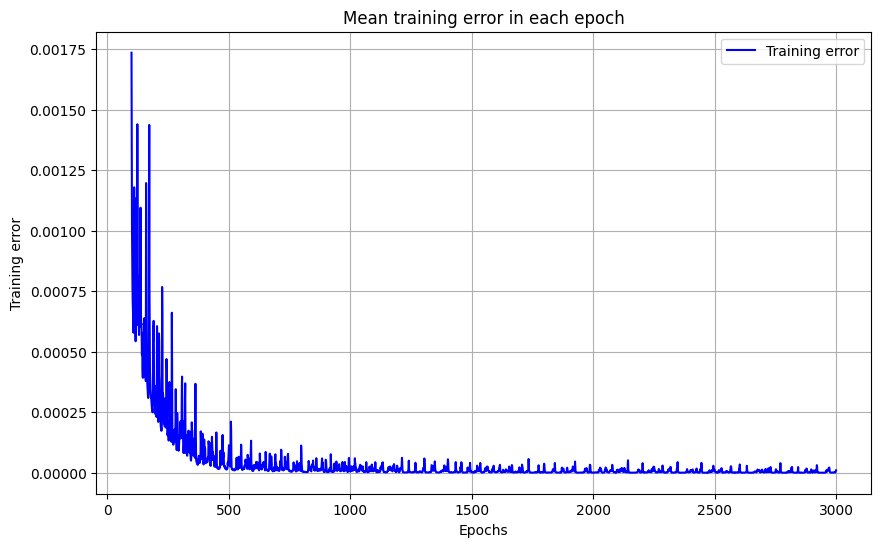

In [70]:
# In this cell, we plot the training error for each epoch

custom_begin = 100
plt.figure(figsize=(10, 6))
plt.plot(range(custom_begin, len(error_epochs)), error_epochs[custom_begin:], label='Training error', color='b')
plt.title('Mean training error in each epoch')
plt.xlabel('Epochs')
plt.ylabel('Training error')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
# In this cell, we computer training and testing loss for the model

with torch.no_grad():
    total_loss = 0
    for input1_batch, input2_batch, target_batch in tqdm(train_loader, desc="Computing training loss"):
        input1_batch = input1_batch.to(device)
        input2_batch = input2_batch.to(device)
        target_batch = target_batch.to(device)
        outputs = model(input1_batch, input2_batch)
        loss = mse(outputs, target_batch)
        total_loss += loss.item()  
        del input1_batch, input2_batch, target_batch, outputs
        torch.cuda.empty_cache()  # 释放当前批次的缓存
    print(f"Train loss: {total_loss/len(train_loader)}")
    
with torch.no_grad():
    total_loss = 0
    for input1_batch, input2_batch, target_batch in tqdm(test_loader, desc="Computing testing loss"):
        input1_batch = input1_batch.to(device)
        input2_batch = input2_batch.to(device)
        target_batch = target_batch.to(device)
        outputs = model(input1_batch, input2_batch)
        loss = mse(outputs, target_batch)
        total_loss += loss.item()  
        del input1_batch, input2_batch, target_batch, outputs
        torch.cuda.empty_cache()  # 释放当前批次的缓存
    print(f"Test loss: {total_loss/len(test_loader)}")

Computing training loss:   0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 3.2338158106881565e-07


Computing testing loss:   0%|          | 0/5 [00:00<?, ?it/s]

Test loss: 4.4399226908353737e-07


In [72]:
# In this cell, we compute the predictions for the entire dataset using the trained model

# 定义对最后一维计算 L2 范数的函数
def l2_norm_last_coord_torch(tensor):
    return torch.norm(tensor, p=2, dim=-1)

all_predictions = torch.zeros((total_sample,total_time_steps*n_points))

with torch.no_grad():
    prediction_list = []
    # 分批处理数据
    for i in tqdm(range(0, total_sample, batch_size), desc="Computing predictions"):
        u_batch = u_expanded[i:i + batch_size].to(device)
        y_batch = y_tensor.to(device)
        s_batch = s_tensor[i:i + batch_size].to(device)
        # Add a new dimension at the beginning, making the shape [total_sample, n_points^2, 2]
        y_batch = y_batch.unsqueeze(0)  # Shape: [1, n_points^2, 2]
        y_batch = y_batch.expand(batch_size, -1, -1)  # Shape: [total_sample, n_points, 2]
        
        prediction = model(u_batch, y_batch).squeeze()
        all_predictions[i:i+batch_size] = prediction.cpu()  # 将预测结果存储并移动到 CPU
    
        del u_batch, y_batch, s_batch
        torch.cuda.empty_cache()  # 释放当前批次的缓存

Computing predictions:   0%|          | 0/25 [00:00<?, ?it/s]

In [73]:
# In this cell, we compute the relative L2 error for the entire dataset, including training and testing sets

# 定义对最后一维计算 L2 范数的函数
def l2_norm_last_coord_torch(tensor):
    return torch.norm(tensor, p=2, dim=-1)

absolute_err = torch.zeros((total_sample,total_time_steps*n_points))
absolute_l2_err = np.zeros(total_sample)
relative_l2_err = np.zeros(total_sample)
for i in tqdm(range(total_sample), desc="Computing relative l2 error for the entire dataset"):
    absolute_err[i] = abs(all_predictions[i] - s_tensor[i])
    absolute_l2_err[i] = l2_norm_last_coord_torch(absolute_err[i])
    relative_l2_err[i] = absolute_l2_err[i] / l2_norm_last_coord_torch(s_tensor[i])
    
train_relative_l2_err = relative_l2_err[:boundary]
test_relative_l2_err = relative_l2_err[boundary:]
train_relative_l2_err = torch.from_numpy(train_relative_l2_err)
test_relative_l2_err = torch.from_numpy(test_relative_l2_err)

Computing relative l2 error for the entire dataset:   0%|          | 0/500 [00:00<?, ?it/s]

In [74]:
# In this cell, we compute the key statistics of the relative L2 error for the training and testing sets, and compare the statistics

# 计算张量的统计量
def get_statistics_torch(tensor):
    stats = {
        'mean': torch.mean(tensor).item(),
        'std': torch.std(tensor).item(),
        'min': torch.min(tensor).item(),
        'median': torch.median(tensor).item(),
        'max': torch.max(tensor).item()
    }
    return stats

# 比较两个张量的统计量
def compare_statistics(statistics1, statistics2):
    comparison = {}
    for key in statistics1.keys():
        comparison[key] = {
            'train': statistics1[key],
            'test': statistics2[key],
            'difference': statistics1[key] - statistics2[key]  # 计算差异
        }
    return comparison

# 获取训练和测试张量的统计量
train_statistics = get_statistics_torch(train_relative_l2_err)
test_statistics = get_statistics_torch(test_relative_l2_err)

# 打印训练和测试统计量
print("Train Relative Statistics:")
for key, value in train_statistics.items():
    print(f'{key}: {value}')

print("\nTest Relative Statistics:")
for key, value in test_statistics.items():
    print(f'{key}: {value}')

# 比较两个统计量并打印结果
comparison = compare_statistics(train_statistics, test_statistics)

print("\nComparison of Train and Test Statistics:")
for key, values in comparison.items():
    print(f"{key}: Train = {values['train']}, Test = {values['test']}, Absolute Difference = {abs(values['difference'])}")

Train Relative Statistics:
mean: 0.006539747543865815
std: 0.004803405529767081
min: 0.001909999642521143
median: 0.004984969273209572
max: 0.0510120615363121

Test Relative Statistics:
mean: 0.007064220341853797
std: 0.004363333760865245
min: 0.0021866129245609045
median: 0.005469889845699072
max: 0.0214915219694376

Comparison of Train and Test Statistics:
mean: Train = 0.006539747543865815, Test = 0.007064220341853797, Absolute Difference = 0.0005244727979879828
std: Train = 0.004803405529767081, Test = 0.004363333760865245, Absolute Difference = 0.00044007176890183564
min: Train = 0.001909999642521143, Test = 0.0021866129245609045, Absolute Difference = 0.00027661328203976154
median: Train = 0.004984969273209572, Test = 0.005469889845699072, Absolute Difference = 0.00048492057248950005
max: Train = 0.0510120615363121, Test = 0.0214915219694376, Absolute Difference = 0.029520539566874504


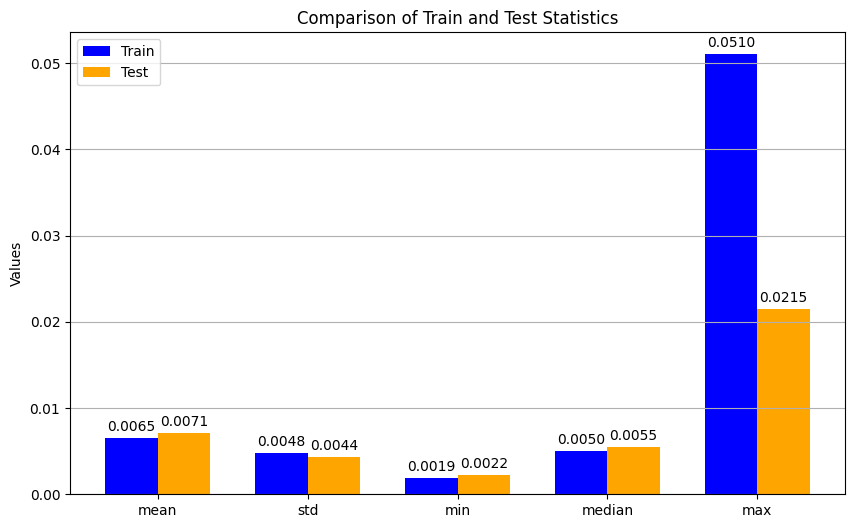

In [75]:
# In this cell, we plot the key statistics of the relative L2 error for the training and testing sets in a bar chart

# 提取统计数据用于绘图
labels = list(train_statistics.keys())
train_values = [train_statistics[key] for key in labels]
test_values = [test_statistics[key] for key in labels]

# 设置绘图
bar_positions = np.arange(len(labels))  # 标签的数量
width = 0.35  # 柱子的宽度

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(bar_positions - width/2, train_values, width, label='Train', color='b')
bars2 = ax.bar(bar_positions + width/2, test_values, width, label='Test', color='orange')

# 添加一些标签和标题
ax.set_ylabel('Values')
ax.set_title('Comparison of Train and Test Statistics')
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels)
ax.legend()

# 添加数据标签，保留更多小数点
def add_data_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',  # 修改为保留四位小数
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 向上偏移
                    textcoords="offset points",
                    ha='center', va='bottom')

add_data_labels(bars1)
add_data_labels(bars2)

plt.grid(axis='y')
plt.show()

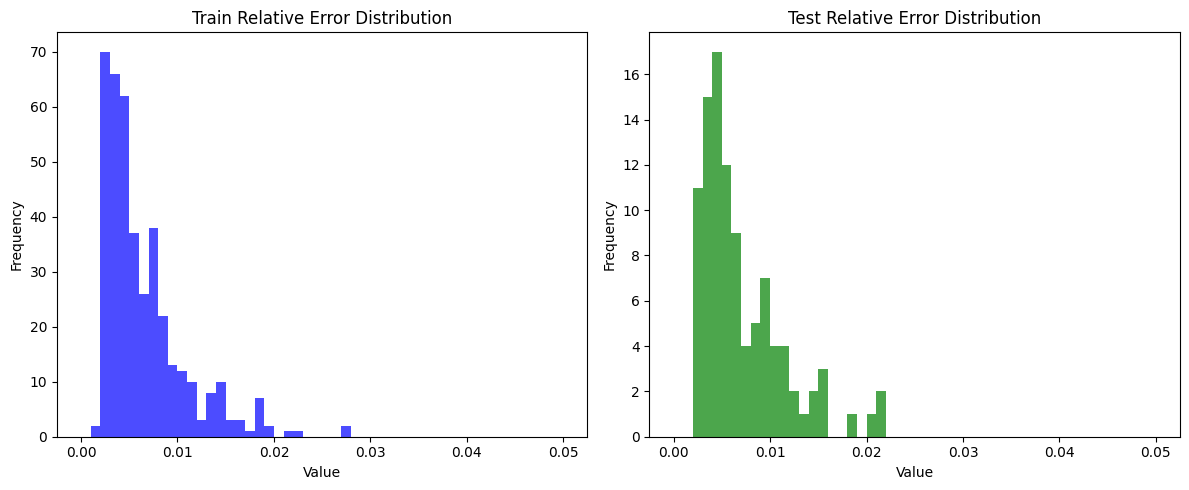

In [76]:
# In this cell, we plot the distribution of the relative L2 error for the training and testing sets

def plot_dual_histogram(tensor1, tensor2, bins=50, range=(0, 0.05), color1='blue', color2='green', 
                        title1='Train Relative Error Distribution', title2='Test Relative Error Distribution'):
    """
    并排绘制两个 1 维张量的直方图。

    参数:
    tensor1: 第一个 1 维张量 (torch.Tensor)
    tensor2: 第二个 1 维张量 (torch.Tensor)
    bins: 直方图的分区数量 (默认值为 30)
    color1: 第一个直方图的颜色 (默认值为 'blue')
    color2: 第二个直方图的颜色 (默认值为 'green')
    title1: 第一个图表的标题 (默认值为 'Tensor 1 Distribution')
    title2: 第二个图表的标题 (默认值为 'Tensor 2 Distribution')
    """
    # 创建两个子图，分别用于绘制两个张量的直方图
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # 绘制第一个张量的直方图
    axs[0].hist(tensor1.numpy(), bins=bins, range = range, alpha=0.7, color=color1)
    axs[0].set_title(title1)
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')

    # 绘制第二个张量的直方图
    axs[1].hist(tensor2.numpy(), bins=bins, range = range, alpha=0.7, color=color2)
    axs[1].set_title(title2)
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Frequency')

    # 显示并排的图像
    plt.tight_layout()
    
    output_image = os.path.join(model_train_directory, f"Var{var}_Sensor{n_points}_Batch{batch_size}.png")
    # 文件名格式

    # 保存图像为 PNG 文件
    plt.savefig(output_image)

    plt.show()
# 使用示例
plot_dual_histogram(train_relative_l2_err, test_relative_l2_err)